In [5]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Softmax, Reshape, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.backend import clear_session


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import copy

# Process dataset
Extract data from the txt file for each user. We only extract the data for the time frame where the user is doing one action, not across different actions. Then we segment the data into 2 seconds window.

In [6]:
# file loader
from os.path import isfile

def load_data(file):
    data = pd.read_csv(file, header=None)
    return data.values

In [7]:
window_size = 75   # 50Hz, 75 samples = 1.5s of movement
window_stride = 25
action_types = ('shield', 'reload', 'grenade', 'final')
data_depth = 6

dataset_users = [0, 1, 2, 3]

# Function to load dataset
def load_dataset(data_dir):
    dataset_x = []
    dataset_y = []
    
    for i in dataset_users:
        user_data_dir = f"{data_dir}/user{i}"
        print(f"Loading data from {user_data_dir}")
    
        for action_type in action_types:

            for i in range(1, 100, 1):
                # if file exists
                if not isfile(user_data_dir + f"/{action_type}{i}.csv"):
                    # print number of files loaded
                    print(f"Loaded {i-1} {action_type} files")
                    break
                data = load_data(user_data_dir + f"/{action_type}{i}.csv")
                dataset_x.append(np.int32(data))
                dataset_y.append(action_types.index(action_type))

    print("Dataset initialized with size: " + str(len(dataset_y)))
    for i in range(len(action_types)):
        print("Class " + str(i) + " has " + str(dataset_y.count(i)) + " samples")
    dataset_y = to_categorical(dataset_y)
    return dataset_x, np.array(dataset_y)

def load_idle_dataset(data_dir):
    dataset_x = []
    dataset_y = []
    
    for i in dataset_users:
        user_data_dir = f"{data_dir}/user{i}"
        print(f"Loading idle data from {user_data_dir}")
    
        for i in range(1, 100, 1):
            # if file exists
            if not isfile(user_data_dir + f"/idle{i}.csv"):
                break
            data = load_data(user_data_dir + f"/idle{i}.csv")
            dataset_x.append(data)
            dataset_y.append([0.25, 0.25, 0.25, 0.25])

    print("Idle dataset initialized with size: " + str(len(dataset_y)))
    return dataset_x, np.array(dataset_y)

# To do sliding window on the data
def sliding_window(data_X, data_Y, window_size, window_stride):
    dataset_X_w_sliding = []
    dataset_Y_w_sliding = []
    for i in range(len(data_X)):
        for j in range(0, len(data_X[i]) - window_size+1, window_stride):
            dataset_X_w_sliding.append(data_X[i][j:j + window_size])
            dataset_Y_w_sliding.append(data_Y[i])
    return np.array(dataset_X_w_sliding), np.array(dataset_Y_w_sliding)


# load dataset
dataset_x, dataset_y = load_dataset("Dataset")

# split into train and test sets
train_x, test_x, train_y, test_y = train_test_split(dataset_x, dataset_y, test_size=0.2, stratify = dataset_y, random_state=66)

# backup test set for evaluation
test_x_eval = copy.deepcopy(test_x)
test_y_eval = copy.deepcopy(test_y)

# combine the training data with idle data
dataset_x_idle, dataset_y_idle = load_idle_dataset("Dataset")
train_x.extend(dataset_x_idle)
train_y = np.concatenate((train_y, dataset_y_idle), axis=0)

# sliding window after train_test_split
train_x, train_y = sliding_window(train_x, train_y, window_size, window_stride)
test_x, test_y = sliding_window(test_x, test_y, window_size, window_stride)

# print dataset size after sliding window
print("Dataset size after sliding window: " + str(len(train_y)))

# calculate class weights
class_weights = {}
for i in range(len(action_types)):
    class_weights[i] = 1 / dataset_y[:, i].sum()

# print dataset disribution
train_y_temp = np.argmax(train_y, axis=1)
for i in range(len(action_types)):
    print("Class " + str(i) + " has " + str(train_y_temp.tolist().count(i)) + " samples")

# backup test_x for c_sim and cosim
test_x_copy = copy.deepcopy(test_x)

# convert data from int16 to float32
train_x, test_x = np.float32(train_x)/4096, np.float32(test_x)/4096
# print("sample test x data: " + str(test_x[0]))

# summary of test dataset
test = np.argmax(test_y, axis=1)
print("\nTest set distribution")
for i in range(len(action_types)):
    print("Class " + str(i) + " has " + str(test.tolist().count(i)) + " samples")


Loading data from Dataset/user0
Loaded 15 shield files
Loaded 15 reload files
Loaded 15 grenade files
Loaded 20 final files
Loading data from Dataset/user1
Loaded 20 shield files
Loaded 15 reload files
Loaded 20 grenade files
Loaded 20 final files
Loading data from Dataset/user2
Loaded 20 shield files
Loaded 13 reload files
Loaded 14 grenade files
Loaded 20 final files
Loading data from Dataset/user3
Loaded 20 shield files
Loaded 14 reload files
Loaded 20 grenade files
Loaded 20 final files
Dataset initialized with size: 281
Class 0 has 75 samples
Class 1 has 57 samples
Class 2 has 69 samples
Class 3 has 80 samples
Loading idle data from Dataset/user0
Loading idle data from Dataset/user1
Loading idle data from Dataset/user2
Loading idle data from Dataset/user3
Idle dataset initialized with size: 20
Dataset size after sliding window: 1736
Class 0 has 857 samples
Class 1 has 232 samples
Class 2 has 289 samples
Class 3 has 358 samples

Test set distribution
Class 0 has 71 samples
Class 1 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 75, 32)            608       
_________________________________________________________________
dropout (Dropout)            (None, 75, 32)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
_________________________________________________________________
softmax (Softmax)            (None, 4)                 0         
Total params: 740
Trainable params: 740
Non-trainable params: 0
_________________________________________________________________


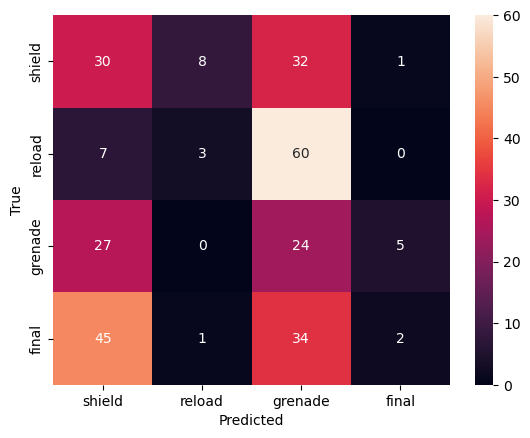

In [8]:
clear_session()
model = Sequential()

conv1filters = 32
conv1kernel = 3
conv1stride = 1
model.add(Conv1D(conv1filters, conv1kernel, strides=conv1stride, padding='same', activation='relu', input_shape=(window_size, 6)))
model.add(Dropout(0.5)) # 50% dropout

# conv2filters = 32
# conv2kernel = 3
# conv2stride = 1
# model.add(Conv1D(conv2filters, conv2kernel, strides=conv2stride, activation='relu'))
# model.add(Dropout(0.5)) # 50% dropout

model.add(GlobalAveragePooling1D())
# model.add(Flatten())

# model.add(Dense(16, activation='relu'))
model.add(Dense(len(action_types)))
model.add(Softmax())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# performance before training
y_prediction = np.argmax(model.predict(test_x), axis=1)
result = confusion_matrix(np.argmax(test_y, axis=1), y_prediction)
sns.heatmap(result, annot=True, fmt="d", xticklabels=action_types, yticklabels=action_types)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [9]:
# checkpoint callback
checkpoint_filepath = "model_checkpoint/"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# learning rate reduce on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=0)

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

In [10]:
import time

# Train the model
def train_network(model, train_x, train_y, test_x, test_y):
    verbose = 1 # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
    epochs = 1000
    batch_size = 32
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_x, test_y), class_weight = class_weights, callbacks = [model_checkpoint_callback, reduce_lr, early_stopping], verbose=verbose)
    # _, accuracy = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)

    return model, history

start_time = time.time()
model, history = train_network(model, train_x, train_y, test_x, test_y)
print("Training time: %s seconds" % (time.time() - start_time))

Epoch 1/1000
55/55 [==============================] - 2s 7ms/step - loss: 0.0186 - accuracy: 0.2880 - val_loss: 1.1747 - val_accuracy: 0.5878
Epoch 2/1000
55/55 [==============================] - 0s 3ms/step - loss: 0.0167 - accuracy: 0.4263 - val_loss: 0.9993 - val_accuracy: 0.7348
Epoch 3/1000
55/55 [==============================] - 0s 3ms/step - loss: 0.0154 - accuracy: 0.4960 - val_loss: 0.8541 - val_accuracy: 0.7778
Epoch 4/1000
55/55 [==============================] - 0s 3ms/step - loss: 0.0145 - accuracy: 0.5259 - val_loss: 0.7501 - val_accuracy: 0.8136
Epoch 5/1000
55/55 [==============================] - 0s 3ms/step - loss: 0.0137 - accuracy: 0.5541 - val_loss: 0.6707 - val_accuracy: 0.8136
Epoch 6/1000
55/55 [==============================] - 0s 3ms/step - loss: 0.0132 - accuracy: 0.5553 - val_loss: 0.6119 - val_accuracy: 0.8280
Epoch 7/1000
55/55 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 0.5662 - val_loss: 0.5684 - val_accuracy: 0.8351
Epoch 

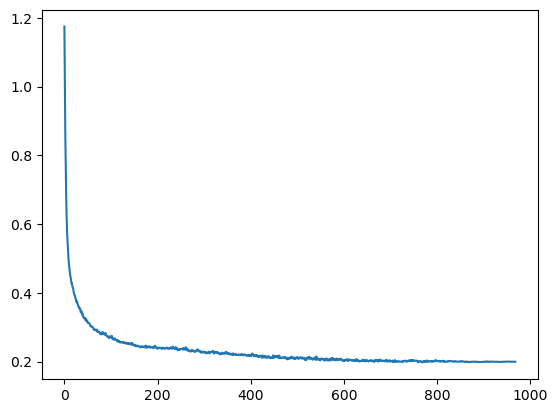

In [11]:
# print validation loss history
plt.plot(history.history['val_loss'])

# Draw confusion matrix

Proportion of filtered prediction: 0.8315412186379928
Highest false confidence: 0.74931496


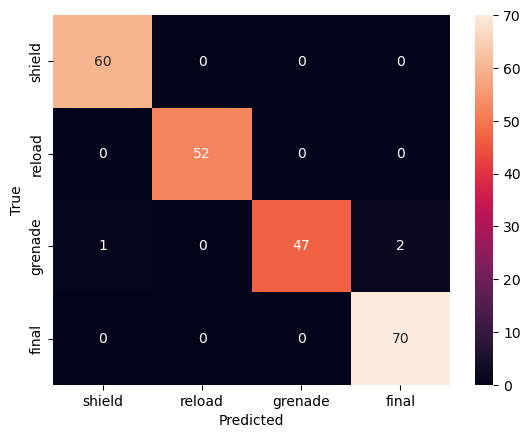

Accuracy: 0.9870689655172413


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

highest_false_confidence = 0

model.load_weights(checkpoint_filepath)
y_prediction = model.predict(test_x)

threshold = 0.7
# remove all the prediction with probability less than threshold
filtered_pred = []
filtered_test = []
for i in range(len(y_prediction)):
    if np.max(y_prediction[i]) > threshold:
        filtered_pred.append(np.argmax(y_prediction[i]))
        filtered_test.append(np.argmax(test_y[i]))
    if np.max(y_prediction[i]) > highest_false_confidence and np.argmax(y_prediction[i]) != np.argmax(test_y[i]):
        highest_false_confidence = np.max(y_prediction[i])

# print proportion of filtered prediction
print("Proportion of filtered prediction: " + str(len(filtered_pred)/len(y_prediction)))

# print highest false confidence
print("Highest false confidence: " + str(highest_false_confidence))

result = confusion_matrix(filtered_test, filtered_pred)

# result = confusion_matrix(np.argmax(test_y, axis=1), y_prediction)
sns.heatmap(result, annot=True, fmt="d", xticklabels=action_types, yticklabels=action_types)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# print accuracy
print("Accuracy: " + str(np.sum(np.diag(result))/np.sum(result)))


prediction ended early at window 121
best prob:  0.722529 w correct predict
prediction ended early at window 22
best prob:  0.7030961 w correct predict
prediction ended early at window 24
best prob:  0.7054882 w correct predict
prediction ended early at window 84
best prob:  0.7182884 w correct predict
prediction ended early at window 80
best prob:  0.7023559 w correct predict
prediction ended early at window 31
best prob:  0.71665555 w correct predict
prediction ended early at window 11
best prob:  0.7034568 w correct predict
prediction ended early at window 28
best prob:  0.70543975 w correct predict
prediction ended early at window 25
best prob:  0.7099615 w correct predict
prediction ended early at window 41
best prob:  0.72204417 w correct predict
prediction ended early at window 111
best prob:  0.7173981 w correct predict
prediction ended early at window 20
best prob:  0.7037336 w correct predict
prediction ended early at window 23
best prob:  0.7034749 w correct predict
predicti

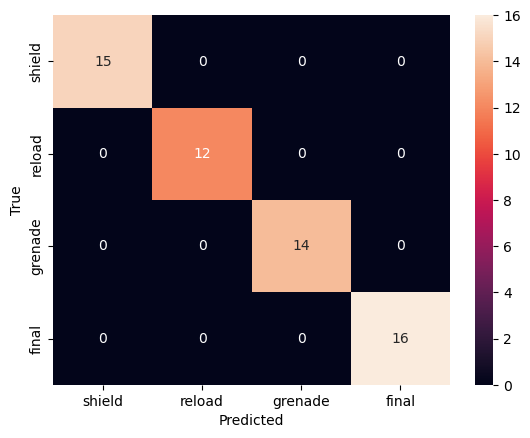

Accuracy: 1.0
Highest false confidence: 0.7965441


In [13]:
# evaluate actual performance
pred = []
actual = []
highest_false_confidence = 0
for i in range(len(test_x_eval)):
    data = np.array(test_x_eval[i])
    # sliding window until the prediction has probability greater than threshold, or end of the sequence and give the prediction with highest probability
    best_pred, best_prob = 0, 0
    batched_data = []
    for w in range(conv1kernel, len(data), conv1stride):
        x = np.array(data[max(0, w-window_size):w])
        x = np.concatenate((np.zeros((window_size - x.shape[0], 6)), x))
        x = np.float32(x)/4096
        batched_data.append(x)
    
    batched_data = np.array(batched_data)
    y = model.predict(batched_data)

    # find the earliest prediction with probability greater than threshold
    prediction_ended = False
    for j in range(len(y)):
        if np.max(y[j]) > highest_false_confidence and np.argmax(y[j]) != np.argmax(test_y_eval[i]):
            highest_false_confidence = np.max(y[j])
        if np.max(y[j]) > best_prob and not prediction_ended:
            best_pred = np.argmax(y[j])
            best_prob = np.max(y[j])
        if np.max(y[j]) > threshold and not prediction_ended:
            print("prediction ended early at window " + str(j))
            prediction_ended = True
    if (not prediction_ended):
        print("prediction ended at END OF SEQUENCE")

    print("best prob: ", str(best_prob), "w correct predict" if best_pred == np.argmax(test_y_eval[i]) else "w wrong predict")
    pred.append(best_pred)
    actual.append(np.argmax(test_y_eval[i]))
result = confusion_matrix(actual, pred)
sns.heatmap(result, annot=True, fmt="d", xticklabels=action_types, yticklabels=action_types)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# print accuracy
print("Accuracy: " + str(np.sum(np.diag(result))/np.sum(result)))

# print highest false confidence
print("Highest false confidence: " + str(highest_false_confidence))

In [ ]:
print(f"window shape: {window_size, data_depth}")
print(f"kernel shape: {conv1kernel, data_depth}")
print(f"first layer weights shape: {model.layers[0].get_weights()[0].shape}")
print(f"first layer output shape: {model.layers[0].output_shape}")
print(f"second layer weights shape: {model.layers[3].get_weights()[0].shape}")
print(f"second layer output shape: {model.layers[3].output_shape}")

In [14]:
# print out weights and biases one by one
layers_indexes = [0, 3, 7]

for layer_index in layers_indexes:
    layer = model.layers[layer_index]
    layer_name = layer.name
    weights = layer.get_weights()
    print(weights[0].shape)
    print(f"INPUT_DTYPE model_param_{layer_name}_weights")
    for i in range(weights[0].shape[-1]):
        print("index", i)
        print(np.transpose(np.transpose(weights[0])[i]))
    print(f"INPUT_DTYPE model_param_{layer_name}_biases")
    print(weights[1].shape)

(4, 6, 32)
INPUT_DTYPE model_param_conv1d_weights
index 0
[[-0.09324597  0.49212477 -0.09019394  0.05808166 -0.04599555 -0.04627829]
 [-0.23262163  0.28205773 -0.10223389 -0.11845943 -0.12053466 -0.00841114]
 [-0.21646444  0.4346303  -0.06791604 -0.09665319 -0.09405329  0.23819032]
 [ 0.13234648  0.4354292  -0.01813824 -0.00582497  0.00357453 -0.07076912]]
index 1
[[-0.23081021  0.08836852 -0.06513091  0.05487993  0.00268359  0.06421239]
 [ 0.0274289   0.12944074 -0.07498191  0.01614072 -0.05147802 -0.12492218]
 [-0.01483522  0.16327304  0.048067    0.09301755  0.08270051 -0.1524584 ]
 [-0.17636919 -0.03372113  0.09822872  0.08538172 -0.12302361  0.10143758]]
index 2
[[-0.0977548  -0.226029    0.1416581  -0.14343943 -0.01179374 -0.02900941]
 [-0.13604102 -0.06979573  0.11093723  0.04052258 -0.08645116  0.07244715]
 [ 0.15629973 -0.22012423  0.18223903  0.04745707 -0.14173844 -0.09341267]
 [ 0.08472694 -0.12118039 -0.03153764 -0.06564689 -0.07077911  0.08762029]]
index 3
[[-0.17860405  

In [16]:
# directly print out weights and biases
layers_indexes = [0, 3, 7]

for layer_index in layers_indexes:
    layer = model.layers[layer_index]
    layer_name = layer.name
    weights = layer.get_weights()
    if layer_index == 0:
        layer_name = "CNN_1"
        weights_size_definition = "[CNN_1_KERNEL_LENGTH][CNN_1_KERNEL_DEPTH][CNN_1_KERNEL_COUNT]"
        bias_size_definition = "[CNN_1_KERNEL_COUNT]"
    elif layer_index == 3:
        layer_name = "CNN_2"
        weights_size_definition = "[CNN_2_KERNEL_LENGTH][CNN_2_KERNEL_DEPTH][CNN_2_KERNEL_COUNT]"
        bias_size_definition = "[CNN_2_KERNEL_COUNT]"
    else:
        layer_name = "dense"
        weights_size_definition = "[DENSE_INPUT_NODES][DENSE_OUTPUT_NODES]"
        bias_size_definition = "[DENSE_OUTPUT_NODES]"
    print(f"static INPUT_DTYPE {layer_name}_weights{weights_size_definition} = {{" + ", ".join([str(x) for x in weights[0].reshape(-1)]) + "};")
    print(f"static INPUT_DTYPE {layer_name}_bias{bias_size_definition} = {{" + ", ".join([str(x) for x in weights[1]]) + "};")

    # save weights and biases to file
    np.save(f"{layer_name}_weights.npy", weights[0])
    np.save(f"{layer_name}_bias.npy", weights[1])


static INPUT_DTYPE CNN_1_weights[CNN_1_KERNEL_LENGTH][CNN_1_KERNEL_DEPTH][CNN_1_KERNEL_COUNT] = {-0.09324597, -0.23081021, -0.0977548, -0.17860405, 0.27824825, 0.108001776, 0.105839044, 0.03676488, 0.12335965, 0.333209, 0.24095593, -0.118081845, -0.0225824, -0.19766521, 0.39311257, 0.24853455, -0.039287884, 0.054192223, -0.0770197, -0.031340808, 0.23456793, -0.0036829722, 0.3619179, -0.18956679, 0.17293638, -0.14631914, 0.21305482, 0.17198113, -0.04303196, 0.18364815, 0.25985098, -0.23352362, 0.49212477, 0.08836852, -0.226029, 0.23855132, -0.05710322, -0.105786264, -0.23805295, -0.31007963, 0.0014815764, 0.40097904, -0.27413872, 0.16964526, -0.092442214, -0.22507825, 0.24072339, 0.0029548449, -0.06629459, 0.045663238, 0.24992219, 0.021495426, 0.41577458, 0.18505862, -0.032823104, 0.2758253, -0.30202672, -0.0436185, 0.10516355, -0.2173725, 0.14874496, -0.21683973, -0.08128203, -0.061253686, -0.09019394, -0.06513091, 0.1416581, -0.3035523, -0.15226284, 0.13495064, 0.000889924, 0.01420187

In [18]:
# directly print out test dataset
n_values_per_line = 10
dataset_size = len(test_x)
# dataset_size = 1
dataset_start_index = 0
print("#define DATASET_SIZE", dataset_size)

# print out float test dataset
print(f"const float test_x[DATASET_SIZE][INPUT_LENGTH][INPUT_DEPTH] = {{")
for text_x_index in range(dataset_start_index, min(test_x.shape[0], dataset_start_index + dataset_size)):
    for datapoint_index in range(0, len(test_x[text_x_index])):
        for i in range(0, len(test_x[text_x_index][datapoint_index]), n_values_per_line):
            print(", ".join([str(x) for x in test_x[text_x_index][datapoint_index][i:i+n_values_per_line]]) + ",")
print("};") 
    
print(f"const int test_y[DATASET_SIZE][DENSE_OUTPUT_NODES] = {{")
for text_x_index in range(dataset_start_index, min(test_x.shape[0], dataset_start_index + dataset_size)):
    for i in range(0, len(test_y[text_x_index]), n_values_per_line):
        print(", ".join([str(int(x)) for x in test_y[text_x_index][i:i+n_values_per_line]]) + ",")
print("};")

# save the test dataset
np.save("test_x.npy", test_x_copy)
np.save("test_y.npy", test_y)

#define DATASET_SIZE 312
const float test_x[DATASET_SIZE][INPUT_LENGTH][INPUT_DEPTH] = {
-0.9313965, -0.31323242, -0.21411133, -0.2241211, -0.40429688, -0.43139648,
-0.93847656, -0.3125, -0.2006836, -0.40356445, -0.54467773, -0.48632812,
-0.93774414, -0.3232422, -0.19091797, -0.46411133, -0.6467285, -0.44555664,
-0.9394531, -0.34643555, -0.17480469, -0.30029297, -0.78271484, -0.4543457,
-0.9382324, -0.35620117, -0.16430664, -0.14111328, -0.87768555, -0.5241699,
-0.9313965, -0.3503418, -0.1574707, -0.1977539, -0.9267578, -0.48266602,
-0.91796875, -0.34887695, -0.1574707, -0.33618164, -0.86083984, -0.39575195,
-0.90063477, -0.35498047, -0.1640625, -0.37524414, -0.71606445, -0.30932617,
-0.88256836, -0.36083984, -0.17333984, -0.34814453, -0.5251465, -0.23242188,
-0.86743164, -0.36499023, -0.18579102, -0.31274414, -0.31713867, -0.15576172,
-0.85546875, -0.36816406, -0.19726562, -0.26123047, -0.13769531, -0.07373047,
-0.84765625, -0.3713379, -0.20629883, -0.16186523, -0.013916016, 0.03125,


In [ ]:
# directly print out test dataset
n_values_per_line = 10
dataset_size = len(test_x)
# dataset_size = 1
dataset_start_index = 0
print("#define DATASET_SIZE", dataset_size)

# print out float test dataset
print(f"const float test_x[DATASET_SIZE][INPUT_LENGTH][INPUT_DEPTH] = {{")
for text_x_index in range(dataset_start_index, min(test_x.shape[0], dataset_start_index + dataset_size)):
    for datapoint_index in range(0, len(test_x[text_x_index])):
        for i in range(0, len(test_x[text_x_index][datapoint_index]), n_values_per_line):
            print(", ".join([str(x) for x in test_x_copy[text_x_index][datapoint_index][i:i+n_values_per_line]]) + ",")
print("};") 
    
print(f"const int test_y[DATASET_SIZE][DENSE_OUTPUT_NODES] = {{")
for text_x_index in range(dataset_start_index, min(test_x.shape[0], dataset_start_index + dataset_size)):
    for i in range(0, len(test_y[text_x_index]), n_values_per_line):
        print(", ".join([str(int(x)) for x in test_y[text_x_index][i:i+n_values_per_line]]) + ",")
print("};")

# save the test dataset
np.save("test_x.npy", test_x_copy)
np.save("test_y.npy", test_y)

#define DATASET_SIZE 312
const float test_x[DATASET_SIZE][INPUT_LENGTH][INPUT_DEPTH] = {
-3815, -1283, -877, -918, -1656, -1767,
-3844, -1280, -822, -1653, -2231, -1992,
-3841, -1324, -782, -1901, -2649, -1825,
-3848, -1419, -716, -1230, -3206, -1861,
-3843, -1459, -673, -578, -3595, -2147,
-3815, -1435, -645, -810, -3796, -1977,
-3760, -1429, -645, -1377, -3526, -1621,
-3689, -1454, -672, -1537, -2933, -1267,
-3615, -1478, -710, -1426, -2151, -952,
-3553, -1495, -761, -1281, -1299, -638,
-3504, -1508, -808, -1070, -564, -302,
-3472, -1521, -845, -663, -57, 128,
-3454, -1539, -872, -140, 142, 498,
-3441, -1548, -893, 367, 124, 711,
-3434, -1539, -915, 588, 76, 759,
-3429, -1521, -940, 485, 70, 718,
-3431, -1519, -968, 319, 111, 666,
-3435, -1527, -985, 414, 86, 558,
-3436, -1536, -983, 511, -8, 321,
-3436, -1517, -975, 409, -210, 125,
-3420, -1498, -967, 90, -147, 109,
-3419, -1497, -963, -61, 30, 169,
-3432, -1510, -959, 106, 146, 229,
-3470, -1527, -935, 335, 156, 230,
-3512, -1538, 

In [ ]:
# print model output without the last layer
from keras.models import Model
model_without_last_layer = Model(inputs=model.input, outputs=model.layers[-2].output)
model_without_last_layer.summary()
predicted_result = model_without_last_layer.predict(test_x)[0]
print(predicted_result.shape)
print(predicted_result)
